<a href="https://colab.research.google.com/github/Samuel2000-Souff/TD_Stat_Rendu/blob/master/TD3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD 3 | Étude de la marge EGT d'un turboréacteur

---

Objectifs du TD :

* pratiquer sur un premier use case concret d'analyse de données de moteurs d'avion
* fonctions glissantes pandas (_rolling_)
* régression linéaire

---

La table fournie contient les données moteurs disposant de l'information "marge EGT" (egthdm) issue
des rapports ACARS. Il s'agit donc uniquement de rapports extraits au décollage (TAKEOFF). On a
récupéré l'ensemble des rapports des moteurs livrés depuis avril 2016.

## 1. Chargement et nettoyage des données

#### 1.1. Chargez les données ACARS à l'aide de la méthode pandas `read_excel`. Explorez les propriétés générales du jeu de données.

Fichier de données : `./data/accars_b.xlsx`.

In [1]:
!git clone https://github.com/MadaneA/MACS3-Statistiques-Descriptives-TDs.git

Cloning into 'MACS3-Statistiques-Descriptives-TDs'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 92 (delta 20), reused 84 (delta 12), pack-reused 0
Unpacking objects: 100% (92/92), done.


In [2]:
import os
os.getcwd()
os.chdir('MACS3-Statistiques-Descriptives-TDs')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as p

In [4]:
acc = pd.read_excel('./data/accars_b.xlsx')
acc.head()

,flight_phase,engine_number,engine_type,aircraft_number,engine_position,airline_classif_environment,brat,cas,cycles,delfn,...,ztoil,zvb1f,zvb1r,zvb2f,zvb2r,zvsv,zwbp1,zwbp2,zwf36,zxm
0,CLIMB,186,10,192,1,Neutral,1.0,151.0,6.0,-0.1146,...,88.0,0.57,0.73,0.12,0.13,8.9,5.0,5.0,5335.0,0.637
1,CLIMB,186,10,192,1,Neutral,1.0,143.0,7.0,-0.2464,...,90.8,0.58,0.76,0.15,0.10,9.0,5.6,5.6,4987.0,0.624
2,CLIMB,186,10,192,1,Neutral,1.0,163.0,8.0,NaN,...,89.0,0.28,0.48,0.16,0.05,10.1,5.0,5.2,4251.0,0.530
3,CLIMB,186,10,192,1,Neutral,1.0,152.0,9.0,NaN,...,87.0,0.44,0.67,0.14,0.08,8.9,5.6,5.6,5356.0,0.380
4,CLIMB,186,10,192,1,Neutral,1.0,154.0,10.0,NaN,...,85.3,0.26,0.48,0.25,0.06,10.5,5.6,5.6,NaN,0.543


In [5]:
acc.shape

(46621, 50)

#### 1.2. Y a-t-il des valeurs manquantes ? Si oui, décrivez leur répartition et affichez le nombre de valeurs manquantes par colonne sous forme d'un bar plot.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [7]:
df = acc.isnull().sum(axis = 'index')
df

flight_phase                       0
engine_number                      0
engine_type                        0
aircraft_number                    0
engine_position                    0
airline_classif_environment      484
brat                               4
cas                            11920
cycles                         30553
delfn                            584
deln1                            584
dtamb                            584
egthdm                          1351
iai                                4
iaie1                            308
iaie2                            308
iaiwg                              4
ibe1                               0
ibe2                               0
ivs12                              0
pcn1k                           1351
sloatl                          1351
tsih                           32885
vbvpos                         27236
wbe                            36699
yn1mod                             4
zalt                              34
z

Text(0.5, 1.0, 'Répartition des valeurs manquantes par colonne')

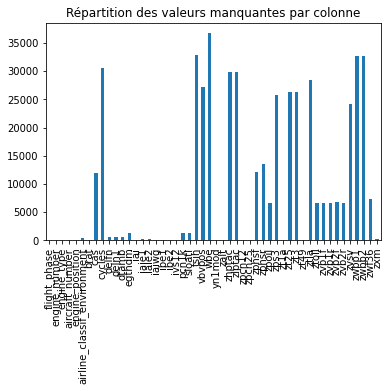

In [8]:
df.plot.bar(df.index)
plt.title('Répartition des valeurs manquantes par colonne')

#### 1.3. Ne gardez que les lignes où le nombre de cycles (variable `cycles`) et la marge EGT (variable `egthdm`) sont présentes.

In [9]:
acc_clean = acc[~acc['egthdm'].isna() & ~acc['cycles'].isna()]
acc_clean.shape

(15374, 50)

#### 1.4. Affichez les différents types de moteurs (indice : utilisez la méthode `unique()`).

In [10]:
acc_clean['engine_type'].unique()

array([10,  5,  7])

#### 1.5. Sélectionnez uniquement les moteurs de type 10. Combien y a-t-il d'avions distincts ? Combien de vols par avion ? (attention : il y a 2 moteurs sur un avion)

In [11]:
vol_type10 = acc_clean[acc_clean['engine_type'] == 10]
print("nombre de d'avions avec un moteur de type 10 :")
print(vol_type10.shape[0])
print("nombre de vol par avion :")
print(vol_type10.shape[1])

nombre de d'avions avec un moteur de type 10 :
712
nombre de vol par avion :
50


## 2. Étude de la marge EGT de l'avion 190

#### 2.1. Récupérez les variables `engine_number`, nombre de cycles (`cycles`) et marge EGT (`egthdm`) pour l'avion identifié par le numéro 190.

In [12]:
avion_190 = vol_type10[vol_type10['aircraft_number'] == 190]
vol_190 = avion_190[['engine_number', 'cycles', 'egthdm']]
vol_190.head()

,engine_number,cycles,egthdm
11398,179,98.0,52.0118
11399,180,69.0,57.6415
11400,180,75.0,48.7217
11755,179,0.0,37.6572
11756,179,1.0,37.2208


In [13]:
print("avion n°190 : ", vol_190.shape[0])

avion n°190 :  220


In [14]:
vol_190

,engine_number,cycles,egthdm
11398,179,98.0,52.0118
11399,180,69.0,57.6415
11400,180,75.0,48.7217
11755,179,0.0,37.6572
11756,179,1.0,37.2208
...,...,...,...
45809,180,48.0,51.9444
45810,180,58.0,59.0032
46111,179,163.0,45.8711
46411,179,30.0,56.5585


#### 2.2. Affichez la courbe de l'évolution de la marge EGT au cours du temps pour les deux moteurs de l'avion, sur deux graphes séparés et en prenant soin d'ajouter des légendes.

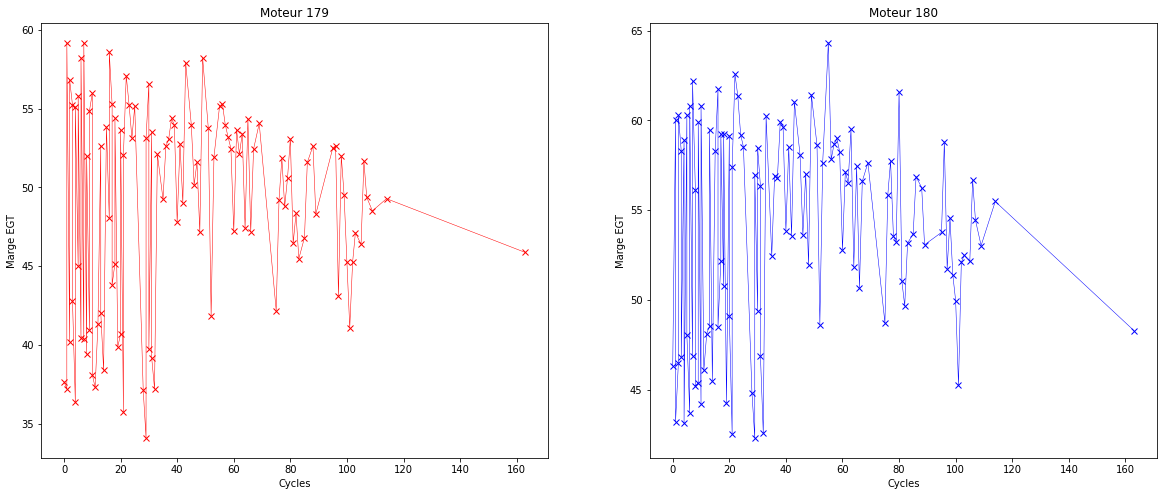

In [15]:
fig,ax = plt.subplots(1, 2, figsize=(20,8))
moteur179 = vol_190[vol_190['engine_number'] == 179].sort_values('cycles')
moteur180 = vol_190[vol_190['engine_number'] == 180].sort_values('cycles')
ax[0].plot(moteur179['cycles'], moteur179['egthdm'], 'rx-', linewidth=0.5)
ax[0].set_title('Moteur 179')
ax[1].plot(moteur180['cycles'], moteur180['egthdm'], 'bx-', linewidth=0.5)
ax[1].set_title('Moteur 180')
for i in [0,1]:
    ax[i].set_xlabel('Cycles')
    ax[i].set_ylabel('Marge EGT')

#### 2.3. Pour la suite, on ne s'intéresse qu'au moteur 179. Quel est le nombre de vols manquant dans les données ?

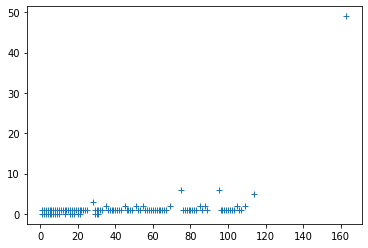

In [16]:
plt.plot(moteur179['cycles'], moteur179['cycles'].diff(1), '+')

In [17]:
print('Nombre de vol manquant :')
nb_manquant = (moteur179['cycles'].diff(1) > 1)
(moteur179['cycles'].diff(1) - 1).where(nb_manquant).sum()

Nombre de vol manquant :


73.0

In [18]:
moteur179['cycles']

11755      0.0
11756      1.0
30796      1.0
11757      2.0
25359      2.0
         ...  
28386    106.0
36515    107.0
42808    109.0
29636    114.0
46111    163.0
Name: cycles, Length: 110, dtype: float64

In [19]:
moteur179['cycles'].diff(1)

11755     NaN
11756     1.0
30796     0.0
11757     1.0
25359     0.0
         ... 
28386     1.0
36515     1.0
42808     2.0
29636     5.0
46111    49.0
Name: cycles, Length: 110, dtype: float64

#### 2.4. Nettoyage de la marge EGT

On constate que sur un même cycle, il peut y avoir 2 valeurs de la variable `egthdm` mesurées. On ne souhaite garder que la plus grande des deux, et avoir une seule ligne par cycle, afin que l'on puisse utiliser le nombre de cycles comme index. Enfin, on veut compléter l'index pour les vols manquants, en remplissant les lignes par `NaN`. Pour cela, effectuez l'exercice suivant:

1. Utilisez une aggrégation pour obtenir la plus grande valeur à chaque cycle et stockez le résultat dans une Series pandas appelée 'egt'.
2. Ré-indexez le DataFrame pour avoir une ligne pour tout nombre de cycles (indice : passez par la méthode reindex).

In [20]:
moteur179

,engine_number,cycles,egthdm
11755,179,0.0,37.6572
11756,179,1.0,37.2208
30796,179,1.0,59.1796
11757,179,2.0,40.2041
25359,179,2.0,56.8104
...,...,...,...
28386,179,106.0,51.6519
36515,179,107.0,49.3682
42808,179,109.0,48.5079
29636,179,114.0,49.2813


In [21]:
# On ne garde que le max egthm pour chaque cycle :
egt = moteur179.groupby('cycles')['egthdm'].max()
print(egt)

cycles
0.0      37.6572
1.0      59.1796
2.0      56.8104
3.0      55.2263
4.0      55.1283
          ...   
106.0    51.6519
107.0    49.3682
109.0    48.5079
114.0    49.2813
163.0    45.8711
Name: egthdm, Length: 91, dtype: float64


In [22]:
# Ré-indexez le DataFrame
egt = egt.reindex(pd.RangeIndex(0, egt.index.max()+1), axis='index')
egt

0      37.6572
1      59.1796
2      56.8104
3      55.2263
4      55.1283
        ...   
159        NaN
160        NaN
161        NaN
162        NaN
163    45.8711
Name: egthdm, Length: 164, dtype: float64

\#### 2.5. On souhaite lisser les valeurs et se débarasser des outliers à l'aide d'une médiane glissante sur 15 cycles. Affichez sur un même graphe la marge EGT brute (points) et la marge lissée (ligne).
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling

Utilisez une fenêtre glissante de taille 15 cycles, avec un minimum de 3 observations non-nulles par fenêtre (paramètre `min_periods`).

Text(0.5, 1.0, 'Marge EGT et Marge Lissée')

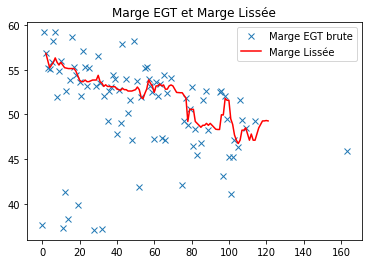

In [23]:
# lisse les valeurs à l'aide d'une médiane glissante sur 15 cycles
egtm = egt.rolling(window = 15, min_periods = 3).median().dropna()
# se débarasser des outliers
egtm = egtm.dropna()

plt.plot(egt.index, egt, 'x') # Marge egt
plt.plot(egtm.index, egtm, c = 'red')    # Marge EGT (médiane sur 15 cycles)

plt.legend(['Marge EGT brute', 'Marge Lissée'])
plt.title('Marge EGT et Marge Lissée')

#### 2.6. Nettoyage de la marge EGT lissée

La marge EGT ne peut être que décroissante, sauf en cas de nettoyage moteur (waterwash) ou peut-être à cause d'éléments extérieurs, on va donc éviter de tenir compte des remontées de marge et ne prendre en considération que les points descendants. Cette estimation est pessimiste mais évite de prendre en compte ces facteurs extérieurs.

1. Calculez une série ne contenant que les valeurs décroissantes de la marge EGT lissée.
2. Sur le graphique précédent, ajoutez ces points par-dessus la courbe.

Text(0.5, 1.0, 'Marge EGT et Marge Lissée')

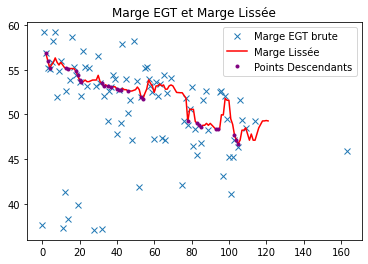

In [24]:
# On ne prend en compte que les points descendants :
egtm_decroit = egtm.rolling(window=egtm.size, min_periods=1).min().drop_duplicates()

plt.plot(egt.index, egt, 'x') # Marge egt
plt.plot(egtm.index, egtm, c = 'red')    # Marge EGT (médiane sur 15 cycles)
plt.plot(egtm_decroit.index, egtm_decroit, '.', c = 'purple')
                              # Points Descendants

plt.legend(['Marge EGT brute', 'Marge Lissée', 'Points Descendants'])
plt.title('Marge EGT et Marge Lissée')

#### 2.7. Estimation de la pente de la marge EGT

La pente de la marge EGT est un indicateur très intéressant de l'usure du moteur. On l'estime par régression linéaire par rapport au nombre de cycles. Pour cela, on utilise les points conservés précédemment qui constituent une estimation pessimiste.

Pour la régression linéaire, on utilisera le modèle `LinearRegression` de scikit-learn. Son utilisation est similaire aux autres modèles de scikit-learn :
```python
lr = LinearRegression()
model = lr.fit(X, y)
```

1. Apprenez un modèle `LinearRegression` sur les données calculées précédemment. Affichez les coefficients et l'ordonnée à l'origine (_intercept_) du modèle obtenu. Les valeurs sont-elles cohérentes ? (indices : pour passer d'un objet pandas (DataFrame ou Series) à un array numpy, utilisez la propriété `values`)
2. Tracez la droite obtenue sur le graphe précédent.

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
len(egt)

164

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


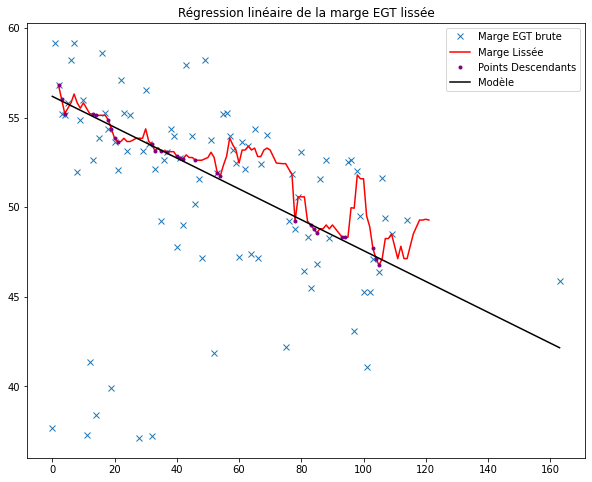

In [27]:
lr = LinearRegression()

# .values : pour passer d'un objet pandas à un array numpy

x = egtm_decroit.index.values.reshape(-1,1)
y = egtm_decroit.values
model = lr.fit(x, y)
taille_egt = len(egt) - 1

plt.figure(figsize = (10,8))

plt.plot(egt.index, egt, 'x')                                 # Marge egt
plt.plot(egtm.index, egtm, c = 'red')                         # Marge egt (médiane sur 15 cycles)
plt.plot(egtm_decroit.index, egtm_decroit, '.', c = 'purple') # Points Descendants

# Ordonne à l'origine
ord_origine = model.intercept_
# Coeffiscients prédis
coef_predict = model.predict(np.array(taille_egt).reshape(-1, 1))

# Tracez la droite obtenue sur le graphe précédent :
plt.plot([0, taille_egt], [ord_origine, coef_predict], c = 'black')

plt.legend(['Marge EGT brute', 'Marge Lissée', 'Points Descendants', 'Modèle'])
plt.title('Régression linéaire de la marge EGT lissée');

### 3. Écriture d'une fonction de calcul de la pente EGT pour tous les moteurs

Tout d'abord, bravo si vous êtes arrivés jusque là ! Toutes les opérations que l'on a effectuées ont permis d'estimer la pente de la marge EGT du moteur 179 de l'avion 190 de type 10, et donc son usure. Maintenant, on souhaite répéter ce processus sur tous les moteurs ! Pour cela, il faudra créer une fonction Python générique, prenant en entrée l'ensemble du jeu de données ACARS et produisant en sortie l'ensemble des pentes/intercept des modèles de régression linéaire appris pour chaque moteur.

L'un des intérêts est de pouvoir prédire l'usure des moteurs, après un nombre de cycles donné.

Voici le squelette de la fonction à écrire (en ré-utilisant et adaptant tout les morceaux de code précédents) :

```python
def regress_egt_margin(df_acars):
    ...
    return df_regress_models # Contient les pentes et intercept pour tous les moteurs
```

### 4. Comparaison de l'usure des 3 types de moteurs

#### 4.1. Prédiction de la marge EGT au 150ème par type de moteur

1. Pour chaque moteur, utilisez son modèle de régression pour prédire la valeur de la marge EGT après 150 cycles d'utilisation (indice : méthode `apply`).
2. Représentez ces valeurs par type moteur sur un box plot. Décrivez le résultat obtenu.
3. Calculez la moyenne de la marge au 150ème cycle par type de moteur. Quel type de moteur a la plus grande marge moyenne après 150 cycles ?

#### 4.3. Vitesse de décroissance de la marge EGT par type de moteur

La pente de la marge EGT correspond à sa vitesse de décroissance par cycle.

1. Quelle est son unité ?
2. Représentez ces valeurs par type de moteur sur un boxplot. Décrivez le résultat obtenu.
3. Calculez moyenne de la pente par type de moteur. Quel type de moteur a la plus faible vitesse de décroissance et donc la plus faible vitesse d'usure ?